In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tscv_sliding
from window_generator import WindowGenerator

In [2]:
from fredapi import Fred
fred_api_key = "29b81578246f3b1d8661dfdb956124ba"
fred = Fred(api_key=fred_api_key)
start_date = "2003-01-02" 
end_date = "2022-12-30"

In [3]:
vix = fred.get_series("VIXCLS", observation_start=start_date, observation_end=end_date).to_frame()
vix.head()

,0
2003-01-02,25.39
2003-01-03,24.68
2003-01-06,24.91
2003-01-07,25.13
2003-01-08,25.53


In [4]:
vix.rename(columns={0:"VIX"}, inplace=True)
vix

,VIX
2003-01-02,25.39
2003-01-03,24.68
2003-01-06,24.91
2003-01-07,25.13
2003-01-08,25.53
...,...
2022-12-26,NaN
2022-12-27,21.65
2022-12-28,22.14
2022-12-29,21.44


In [5]:
vix.fillna(method="ffill", inplace=True)

In [6]:
n = len(vix)
n_train = int(n*0.7)
n_val = int(n*0.9)
train_df = vix[0:n_train]
val_df = vix[n_train:n_val]
test_df = vix[n_val:]

In [7]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3651, 1)
(1044, 1)
(522, 1)


In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

cols = train_df.columns
train_indices = train_df.index
val_indices = val_df.index
test_indices = test_df.index

scale = MinMaxScaler()
train_df = scale.fit_transform(train_df)
val_df = scale.transform(val_df)
test_df = scale.transform(test_df)

train_df = pd.DataFrame(train_df, columns=cols, index=train_indices)
val_df = pd.DataFrame(val_df, columns=cols, index=val_indices)
test_df = pd.DataFrame(test_df, columns=cols, index=test_indices)
train_df.head()

,VIX
2003-01-02,0.218402
2003-01-03,0.208398
2003-01-06,0.211639
2003-01-07,0.214739
2003-01-08,0.220375


In [9]:
input_width = 30

In [10]:
from sklearn.preprocessing import RobustScaler
w = WindowGenerator(input_width=input_width, 
                    label_width=1,
                    shift=1,
                    train_df=train_df,
                    val_df=val_df,
                    test_df=test_df,
                    n_splits=5,
                    train_splits=3,
                    test_splits=1)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [12]:
def qlike(y_true, y_pred):
  return tf.math.log(y_pred) + (y_true / y_pred)

def build_model():
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(input_width, 1))) #(timesteps, features)
    model.add(LSTM(96, return_sequences=True)) #96 #192 #160
    #model.add(LSTM(256, return_sequences=True)) # #256 #(192)
    model.add(LSTM(64)) #64 
    model.add(Dropout(0.2)) #0.2 #0.1 #0.2
    model.add(Dense(1, activation="relu"))
    
    learning_rate = 0.001 #0.001 #0.0001 #0.001
    metrics = ["mse", "mae", "mape", tf.keras.metrics.RootMeanSquaredError(), qlike]
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics = metrics)
    return model
 

In [13]:
MAX_EPOCHS = 50
model = build_model()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=5)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-05-03 14:12:29.301046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-03 14:12:29.301195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
history = model.fit(w.train, epochs=MAX_EPOCHS,
                      validation_data=w.val,
                      callbacks=[early_stopping])

Epoch 1/50


2023-05-03 14:12:30.098293: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-03 14:12:32.402884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-03 14:12:32.802274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-03 14:12:32.917913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-03 14:12:32.991121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-03 14:12:33.169428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-03 14:12:33.358867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

  3/114 [..............................] - ETA: 4s - loss: 0.0410 - mse: 0.0410 - mae: 0.1814 - mape: 81.8487 - root_mean_squared_error: 0.2024 - qlike: nan  

2023-05-03 14:12:33.478339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


114/114 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0073 - mae: 0.0569 - mape: 11830.5635 - root_mean_squared_error: 0.0853 - qlike: nan

2023-05-03 14:12:38.118835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-03 14:12:38.270605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-03 14:12:38.325683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-03 14:12:38.390647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


114/114 [==============================] - 9s 49ms/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0569 - mape: 11830.5635 - root_mean_squared_error: 0.0853 - qlike: nan - val_loss: 0.0137 - val_mse: 0.0137 - val_mae: 0.0746 - val_mape: 231120.9844 - val_root_mean_squared_error: 0.1171 - val_qlike: -1.3129
Epoch 2/50
114/114 [==============================] - 5s 40ms/step - loss: 0.0090 - mse: 0.0090 - mae: 0.0618 - mape: 4703.5210 - root_mean_squared_error: 0.0947 - qlike: -1.1754 - val_loss: 0.0103 - val_mse: 0.0103 - val_mae: 0.0653 - val_mape: 217818.3906 - val_root_mean_squared_error: 0.1015 - val_qlike: -1.3820
Epoch 3/50
114/114 [==============================] - 4s 39ms/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0517 - mape: 2504.0935 - root_mean_squared_error: 0.0804 - qlike: -1.2383 - val_loss: 0.0068 - val_mse: 0.0068 - val_mae: 0.0499 - val_mape: 152553.2188 - val_root_mean_squared_error: 0.0823 - val_qlike: -1.4902
Epoch 4/50
114/114 [==============================] - 4s 39ms/s

In [15]:
ar_width = 200
shift = ar_width - input_width

test = np.concatenate([x for x, y in w.test], axis=0)
predictions = model.predict(test)
y = np.concatenate([y for x, y in w.test], axis=0).reshape(-1, 1)

predicted = scale.inverse_transform(predictions).flatten()[shift:]
actual = scale.inverse_transform(y).flatten()[shift:]
predicted.shape

2023-05-03 14:15:01.790360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-03 14:15:01.921972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-03 14:15:01.980652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/16 [============>.................] - ETA: 0s

2023-05-03 14:15:02.048605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 27ms/step


(322,)

<AxesSubplot: >

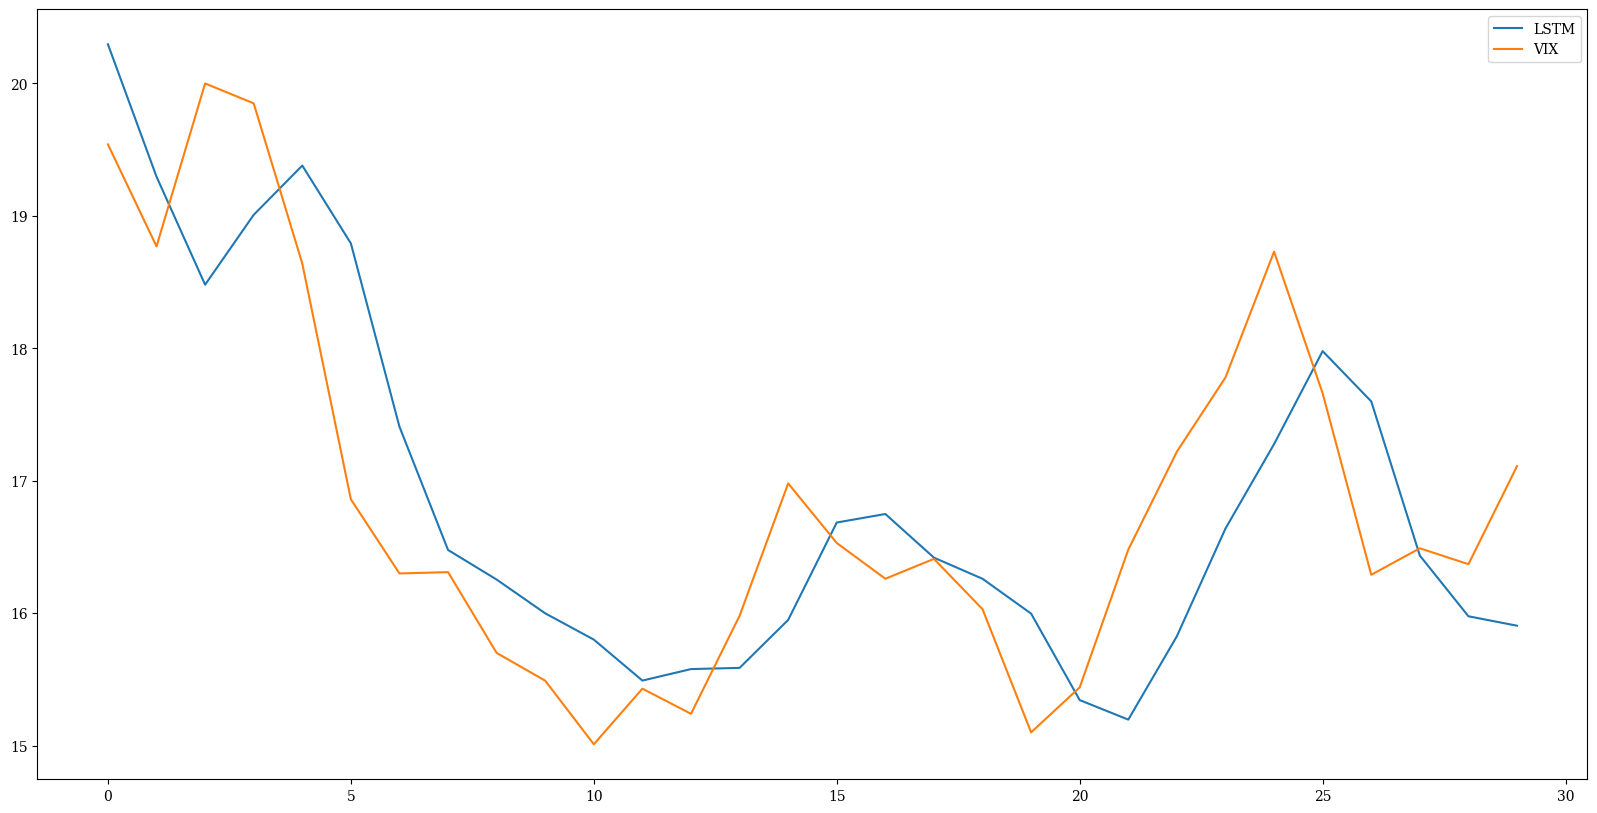

In [42]:
fig, ax = plt.subplots(figsize=(20,10))
timesteps = np.array([i for  i in range(len(predicted))])
n = 30
sns.lineplot(ax = ax, x = timesteps[0:n], y = predicted[0:n], label = 'LSTM')
sns.lineplot(ax = ax, x = timesteps[0:n], y = actual[0:n], label = 'VIX')

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse =  mean_squared_error(actual, predicted)
mae =  mean_absolute_error(actual, predicted)

print("MSE: ", mse)
print("MAE: ", mae)

MSE:  4.2109404
MAE:  1.4426368


In [113]:
import numpy as np

def mda(actual, predicted):
    """
    Calculates the Mean Directional Accuracy (MDA) for two time series.
    
    Parameters:
    actual (array-like): The actual values for the time series.
    predicted (array-like): The predicted values for the time series.
    
    Returns:
    float: The MDA value.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # calculate the signs of the differences between consecutive values
    actual_diff = np.diff(actual)
    actual_signs = np.sign(actual_diff)
    predicted_diff = np.diff(predicted)
    predicted_signs = np.sign(predicted_diff)
    
    # count the number of times the signs are the same
    num_correct = np.sum(actual_signs == predicted_signs)
    
    # calculate the MDA value
    mda = num_correct / (len(actual) - 1)
    
    return mda

mda(actual, predicted)

0.46105919003115264

In [96]:
import shap

y_train = np.concatenate([y for x, y in w.train], axis=0)
x_train = np.concatenate([x for x, y in w.train], axis=0)

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, x_train[:100])

Econometric benchmark

In [18]:
input_width_ar = ar_width

ar_w = WindowGenerator(input_width=input_width_ar, 
                    label_width=1,
                    shift=1,
                    train_df=train_df,
                    val_df=val_df,
                    test_df=test_df,
                    n_splits=3,
                    train_splits=3,
                    test_splits=1,
                    scale=False)

In [19]:
y_test = np.concatenate([y for x, y in ar_w.test], axis=0)
x_test = np.concatenate([x for x, y in ar_w.test], axis=0)

In [21]:
from statsmodels.tsa.ar_model import AutoReg

predictions = []
resid = []

for x, y in zip(x_test, y_test):
    arima_model = AutoReg(endog=x, lags=3).fit()
    day_ahead = x_test.shape[1] + 1
    predictions.append(arima_model.predict(day_ahead, day_ahead))
    resid.append(y[0] - arima_model.predict(day_ahead, day_ahead))

(322, 1)
(492,)


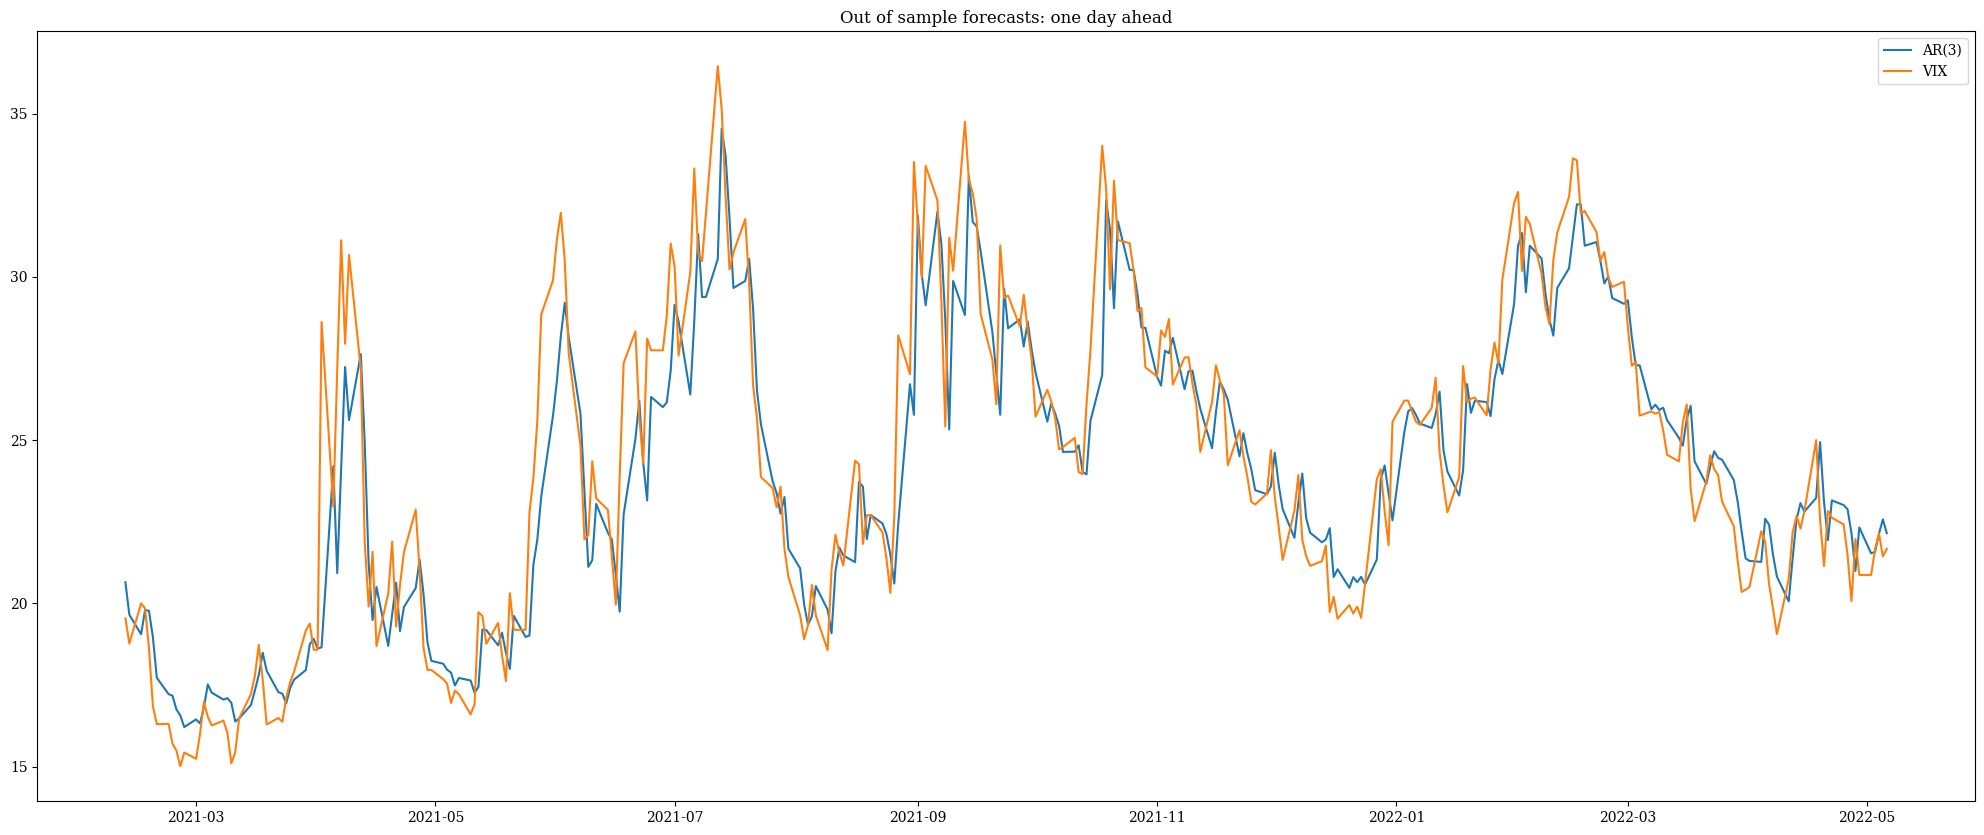

In [22]:
dates = np.arange(1, len(predictions) + 1)

y = scale.inverse_transform(y_test.reshape((len(predictions), -1)))
predictions = scale.inverse_transform(np.array(predictions))
print(y.shape)


dates = test_indices[input_width:]
print(dates.shape)

fig, ax = plt.subplots(figsize = (25,10))

n = 322 # How many days to see in plot

plt.plot(dates[:n], predictions[:n], label = "AR(3)")
plt.plot(dates[:n], y[:n], label = "VIX")
plt.title("Out of sample forecasts: one day ahead")
plt.legend()

In [111]:
mse = mean_squared_error(y, predictions)
mae = mean_absolute_error(y, predictions)

print("MSE: ", mse)
print("MAE: ", mae)

MSE:  3.7447612996363278
MAE:  1.3285389469830495


Bayesian model

In [29]:
import tensorflow_probability as tfp
tfd = tfp.distributions

negloglik = lambda y, rv_y: -rv_y.log_prob(y)

n_samples = np.concatenate([x for x, y in w.train], axis=0).shape[0]

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [30]:
def build_bnn():
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(input_width, 1))) #(timesteps, features)
    model.add(LSTM(96, return_sequences=True)) #96 #192 #160
    #model.add(LSTM(256, return_sequences=True)) # #256 #(192)
    model.add(LSTM(64)) #64 
    model.add(Dropout(0.2)) #0.2 #0.1 #0.2
    model.add(tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/n_samples))
    #model.add(Dense(1, activation="relu"))
    
    learning_rate = 0.001 #0.001 #0.0001 #0.001
    metrics = ["mse", "mae", "mape", tf.keras.metrics.RootMeanSquaredError(), qlike]
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate), metrics = metrics)
    return model

In [31]:
bnn = build_bnn()
bnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 32)            4352      
                                                                 
 lstm_7 (LSTM)               (None, 30, 96)            49536     
                                                                 
 lstm_8 (LSTM)               (None, 64)                41216     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_variational_1 (DenseV  (None, 1)                195       
 ariational)                                                     
                                                                 
Total params: 95,299
Trainable params: 95,299
Non-trainable params: 0
__________________________________________________

In [117]:
MAX_EPOCHS = 500
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=10)

In [118]:
history = bnn.fit(w.train, epochs=MAX_EPOCHS,
                      validation_data=w.val,
                      callbacks=[early_stopping])

Epoch 1/500
114/114 [==============================] - 5s 43ms/step - loss: 0.0021 - mse: 0.0010 - mae: 0.0231 - mape: 3345.8623 - root_mean_squared_error: 0.0322 - qlike: nan - val_loss: 0.0025 - val_mse: 0.0014 - val_mae: 0.0236 - val_mape: 61310.0078 - val_root_mean_squared_error: 0.0371 - val_qlike: nan
Epoch 2/500
114/114 [==============================] - 5s 47ms/step - loss: 0.0019 - mse: 8.0893e-04 - mae: 0.0203 - mape: 11870.1289 - root_mean_squared_error: 0.0284 - qlike: nan - val_loss: 0.0024 - val_mse: 0.0013 - val_mae: 0.0226 - val_mape: 74624.2266 - val_root_mean_squared_error: 0.0358 - val_qlike: nan
Epoch 3/500
114/114 [==============================] - 5s 43ms/step - loss: 0.0020 - mse: 8.5136e-04 - mae: 0.0212 - mape: 8943.5000 - root_mean_squared_error: 0.0292 - qlike: nan - val_loss: 0.0024 - val_mse: 0.0012 - val_mae: 0.0231 - val_mape: 74271.6172 - val_root_mean_squared_error: 0.0351 - val_qlike: nan
Epoch 4/500
114/114 [==============================] - 5s 42ms/s

In [119]:
b_x = np.concatenate([x for x, y in w.test], axis = 0)
b_y = np.concatenate([y for x, y in w.test], axis = 0)

ensemble = []

for i in range(100):
    ensemble.append(bnn(b_x))

ensemble = scale.inverse_transform(np.array(ensemble).reshape((100, -1)))

mean = np.mean(ensemble, axis = 0)
std = np.std(ensemble, axis = 0)

b_y = scale.inverse_transform(b_y.reshape((len(mean), -1)))


In [120]:
b_y.shape

(492, 1)

In [121]:
mse = mean_squared_error(b_y, mean)
mae = mean_absolute_error(b_y, mean)

print("MSE: ", mse)
print("MAE: ", mae)

MSE:  3.3245404
MAE:  1.2505498


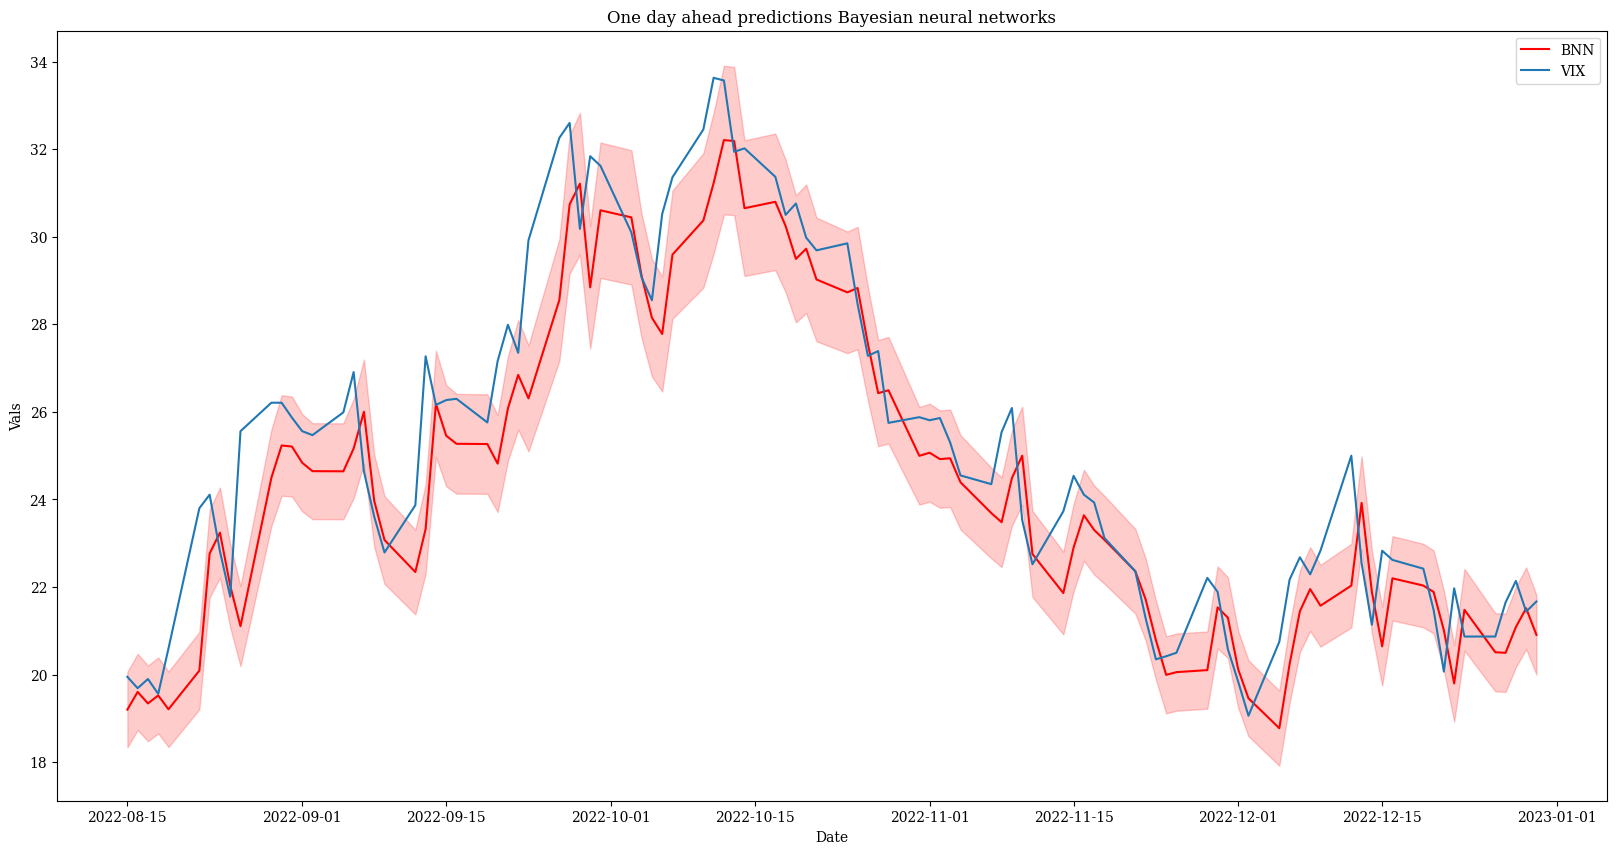

In [122]:
test_df = vix[n_val:]

mean = mean.flatten()
b_y = b_y.flatten()

n = 100


preds_interval = pd.DataFrame(ensemble.T, index = test_indices[30:])
preds_interval = preds_interval.tail(n)
preds_interval['Date'] = test_indices[-n:]
preds_interval = preds_interval.melt(id_vars = 'Date', var_name = 'Labels', value_name = 'Vals')

timesteps = np.array([i for  i in range(len(mean))])

actual_interval = pd.DataFrame([test_indices[30:], b_y]).T
actual_interval.columns = ["Date", "Vals"]


fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(ax = ax, data = preds_interval, x = 'Date', y = 'Vals', color = "r", label="BNN", errorbar=("sd"))
sns.lineplot(ax = ax, data = test_df.tail(n))
plt.title("One day ahead predictions Bayesian neural networks")
plt.legend()
plt.show()

Text(0, 0.5, 'Prediction standard deviation')

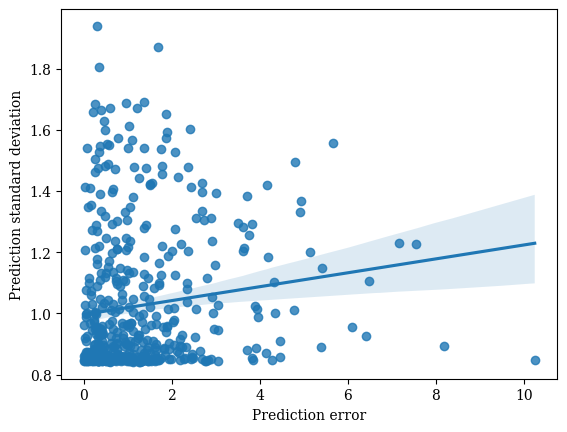

In [123]:
resid = np.abs(b_y - mean)

sns.regplot(x = resid, y = std)
plt.xlabel("Prediction error")

plt.ylabel("Prediction standard deviation")

In [124]:
mda(b_y, mean)

0.48879837067209775

Asymmetric loss function? Discussion around loss function.